# IMGP - Supervised Learning - 1D Manifold

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models import RiemannGP, VanillaGP
from manifold_gp.utils import manifold_1D_dataset, vanilla_train, manifold_informed_train, test_model, beautify, colorbar, colormap_diverging, colormap_left, colormap_right

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset

In [2]:
num_train = 10
normalize_x, normalize_y = False, True
noise_sampled_x, noise_train_y, noise_test_y = 0., 0.01, 0.

In [3]:
sampled_x, sampled_y, edges = manifold_1D_dataset()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
sampled_x = sampled_x.contiguous().to(device)
sampled_y = sampled_y.contiguous().to(device)

if noise_sampled_x != 0.:
    sampled_x += noise_sampled_x * torch.randn(*sampled_x.shape, device=device)

torch.manual_seed(1337)
train_idx = torch.zeros(sampled_x.shape[0]).scatter_(0, torch.randperm(sampled_x.shape[0])[:num_train], 1).bool()
train_x, test_x, train_y, test_y = sampled_x[train_idx], sampled_x[~train_idx], sampled_y[train_idx], sampled_y[~train_idx]

if noise_train_y != 0.:
    train_y += noise_train_y * torch.randn(*train_y.shape, device=device)
if noise_test_y != 0.:
    test_y += noise_test_y * torch.randn(*test_y.shape, device=device)
    
if normalize_x:
    mu_x, std_x = sampled_x.mean(dim=-2, keepdim=True), sampled_x.std(dim=-2, keepdim=True) + 1e-6
    sampled_x.sub_(mu_x).div_(std_x)
    train_x.sub_(mu_x).div_(std_x)
    test_x.sub_(mu_x).div_(std_x)
if normalize_y:
    mu_y, std_y = train_y.mean(), train_y.std()
    sampled_y.sub_(mu_y).div_(std_y)
    train_y.sub_(mu_y).div_(std_y)
    test_y.sub_(mu_y).div_(std_y)

## Model

In [4]:
%%capture
model_vanilla = VanillaGP(
    train_x, 
    train_y, 
    gpytorch.likelihoods.GaussianLikelihood(), 
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
).to(device)

hypers_vanilla = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.lengthscale': 1.0,
    'covar_module.outputscale': 1.0,
}
model_vanilla.initialize(**hypers_vanilla)

In [5]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=1,
        x=sampled_x,
        nearest_neighbors=10,
        laplacian_normalization="randomwalk",
        num_modes=50,
        bump_scale=5.0,
        bump_decay=0.01,
    )
)

model = RiemannGP(train_x, train_y, likelihood, kernel, train_idx).to(device)

hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.graphbandwidth': 0.5,
    'covar_module.base_kernel.lengthscale': 1.0,
    'covar_module.outputscale': 1.0,
}
model.initialize(**hypers)

## Train

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200, threshold=1e-3, threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-8, verbose=False)
loss = manifold_informed_train(model, optimizer, max_iter=200, tolerance=1e-2, update_norm=50, num_rand_vec=100,
                               max_cholesky=1000, cg_tolerance=1e-3, cg_max_iter=1000, scheduler=None, verbose=True)

/home/bernardo/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:46: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iteration: 0, Loss: 17.392, Noise Variance: 0.095, Signal Variance: 0.730, Lengthscale: 0.938, Graphbandwidth: 0.462
Iteration: 1, Loss: 16.541, Noise Variance: 0.091, Signal Variance: 0.758, Lengthscale: 0.878, Graphbandwidth: 0.426
Iteration: 2, Loss: 15.753, Noise Variance: 0.086, Signal Variance: 0.787, Lengthscale: 0.822, Graphbandwidth: 0.393
Iteration: 3, Loss: 15.047, Noise Variance: 0.082, Signal Variance: 0.816, Lengthscale: 0.768, Graphbandwidth: 0.362
Iteration: 4, Loss: 14.449, Noise Variance: 0.078, Signal Variance: 0.844, Lengthscale: 0.717, Graphbandwidth: 0.333
Iteration: 5, Loss: 13.986, Noise Variance: 0.074, Signal Variance: 0.872, Lengthscale: 0.671, Graphbandwidth: 0.307
Iteration: 6, Loss: 13.687, Noise Variance: 0.071, Signal Variance: 0.898, Lengthscale: 0.629, Graphbandwidth: 0.284
Iteration: 7, Loss: 13.575, Noise Variance: 0.068, Signal Variance: 0.922, Lengthscale: 0.594, Graphbandwidth: 0.265
Iteration: 8, Loss: 13.642, Noise Variance: 0.066, Signal Varian

In [7]:
optimizer_vanilla = torch.optim.Adam(model_vanilla.parameters(), lr=1e-1, weight_decay=1e-8)
scheduler_vanilla = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_vanilla, mode='min', factor=0.5, patience=200, threshold=1e-3, 
                                                               threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-8, verbose=False)
loss = vanilla_train(model_vanilla, optimizer_vanilla, max_iter=300, max_cholesky=800, tolerance=1e-2, cg_tolerance=1e-2, cg_max_iter=1000, scheduler=None, 
              verbose=True)

Iteration: 0, Loss: 7.235, Noise Variance: 0.105, Signal Variance: 1.032, Lengthscale: 0.938
Iteration: 1, Loss: 5.819, Noise Variance: 0.110, Signal Variance: 1.063, Lengthscale: 0.879
Iteration: 2, Loss: 4.722, Noise Variance: 0.116, Signal Variance: 1.093, Lengthscale: 0.824
Iteration: 3, Loss: 3.875, Noise Variance: 0.121, Signal Variance: 1.123, Lengthscale: 0.772
Iteration: 4, Loss: 3.219, Noise Variance: 0.127, Signal Variance: 1.151, Lengthscale: 0.724
Iteration: 5, Loss: 2.711, Noise Variance: 0.132, Signal Variance: 1.178, Lengthscale: 0.680
Iteration: 6, Loss: 2.316, Noise Variance: 0.138, Signal Variance: 1.203, Lengthscale: 0.639
Iteration: 7, Loss: 2.010, Noise Variance: 0.143, Signal Variance: 1.227, Lengthscale: 0.602
Iteration: 8, Loss: 1.775, Noise Variance: 0.148, Signal Variance: 1.250, Lengthscale: 0.568
Iteration: 9, Loss: 1.594, Noise Variance: 0.153, Signal Variance: 1.271, Lengthscale: 0.537
Iteration: 10, Loss: 1.456, Noise Variance: 0.157, Signal Variance: 1.

## Evaluation

In [8]:
rmse, nll = test_model(model, test_x, test_y, max_cholesky=2000, cg_tolerance=1e-2, cg_iterations=1000)
print("RMSE Geometric: ", rmse)
print("NLL Geometric: ", nll)

RMSE Geometric:  tensor(0.6646, device='cuda:0')
NLL Geometric:  tensor(-3.0665, device='cuda:0')


In [8]:
rmse_vanilla, nll_vanilla = test_model(model_vanilla, test_x, test_y, max_cholesky=2000, cg_tolerance=1e-2, cg_iterations=1000)
print("RMSE Vanilla: ", rmse_vanilla)
print("NLL Vanilla: ", nll_vanilla)

RMSE Vanilla:  tensor(1.3854, device='cuda:0')
NLL Vanilla:  tensor(5.8751, device='cuda:0')


## Plot

In [9]:
resolution = 100
x, y = torch.meshgrid(torch.linspace(-2., 2., resolution), torch.linspace(-1., 1., resolution), indexing='xy')
grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device)
if normalize_x:
    grid_x.sub_(mu_x).div_(std_x)
sampled_x = sampled_x.contiguous().to(device)
kernel_center = 864

In [11]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cholesky_size(2000), gpytorch.settings.cg_tolerance(1e-2),  gpytorch.settings.max_cg_iterations(1000):
    model.posterior(sampled_x, noisy_posterior=False, base_model=model_vanilla)
    mean_manifold = model.posterior_geom.mean.cpu().numpy()
    std_manifold = model.posterior_geom.stddev.cpu().numpy()
    kernel_manifold = (kernel.base_kernel(sampled_x[kernel_center, :].unsqueeze(0), sampled_x).evaluate()/
                       kernel.base_kernel(sampled_x[kernel_center, :].unsqueeze(0), sampled_x[kernel_center, :].unsqueeze(0)).evaluate()).squeeze().cpu().numpy()
    feature_manifold = kernel.base_kernel.features(sampled_x)[:,3].cpu().numpy()
    bump_manifold = 1 - model.base_scale.cpu().numpy()
    
    model.posterior(grid_x, noisy_posterior=False, base_model=model_vanilla)
    mean_ambient = model.posterior_geom.mean.cpu().numpy().reshape(resolution, -1)
    std_ambient = model.posterior_geom.stddev.cpu().numpy().reshape(resolution, -1)
    kernel_ambient = (kernel.base_kernel(sampled_x[kernel_center, :].unsqueeze(0), grid_x).evaluate()/
                      kernel.base_kernel(sampled_x[kernel_center, :].unsqueeze(0), sampled_x[kernel_center, :].unsqueeze(0)).evaluate()).squeeze().cpu().numpy().reshape(resolution, -1)
    feature_ambient = kernel.base_kernel.features(grid_x)[:,3].cpu().numpy().reshape(resolution, -1)
    bump_ambient = 1 - model.base_scale.cpu().numpy().reshape(resolution, -1)

x, y = x.numpy(), y.numpy()
sampled_x = sampled_x.cpu().numpy()
sampled_y = sampled_y.cpu().numpy()

/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [12]:
vmin, vmax = -1.85, 1.85
cmap_mean = colormap_diverging(colormap='Spectral_r', vmin=vmin, vmax=vmax, center_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)
cmap_std = colormap_right(colormap='afmhot', right_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)
cmap_kernel = colormap_left(colormap='afmhot_r', left_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)
cmap_feature = colormap_diverging(colormap='Spectral_r', vmin=feature_ambient.min(), vmax=feature_ambient.max(), center_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)

### Ground Truth

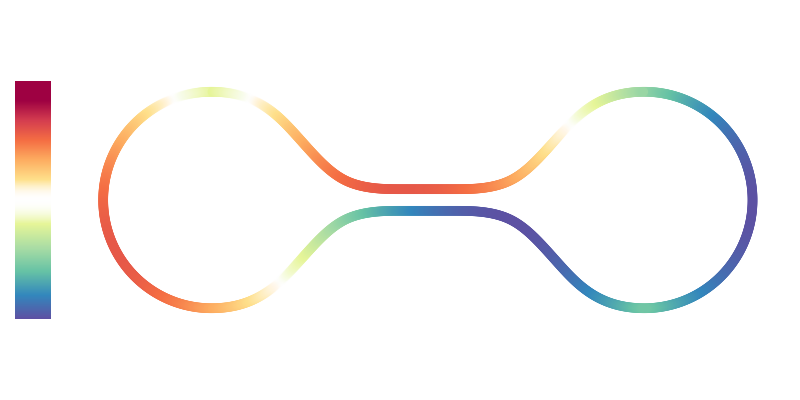

In [13]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
im = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=sampled_y, vmin=vmin, vmax=vmax, cmap=cmap_mean)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)

### Manifold Posterior Mean

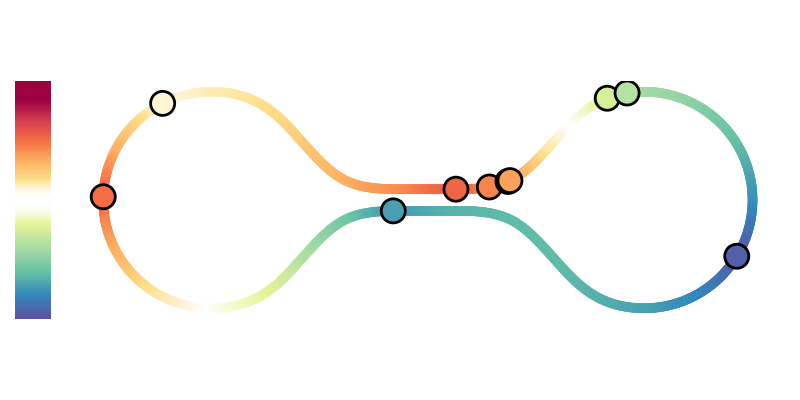

In [14]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
im = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=mean_manifold, vmin=vmin, vmax=vmax, cmap=cmap_mean)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c=mean_manifold[train_idx], s=300.0, zorder=2, 
           edgecolors='black', linewidth=2, alpha=1.0, vmin=vmin, vmax=vmax, cmap=cmap_mean)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)

### Ambient Posterior Mean

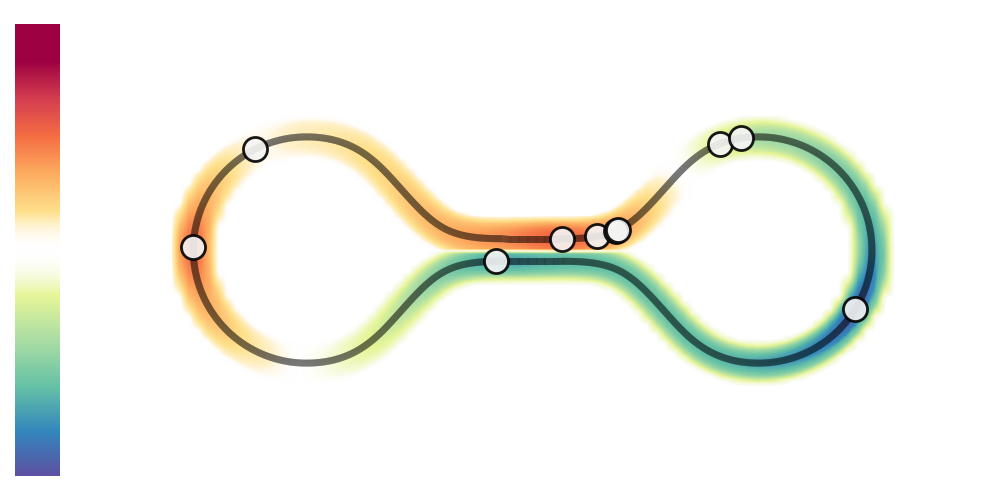

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x, y, mean_ambient, levels=np.linspace(vmin, vmax, 500), cmap=cmap_mean)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
           edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = sampled_x[edge[0]]
    end = sampled_x[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth=5, alpha=0.1)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

### Manifold Posterior Standard Deviation

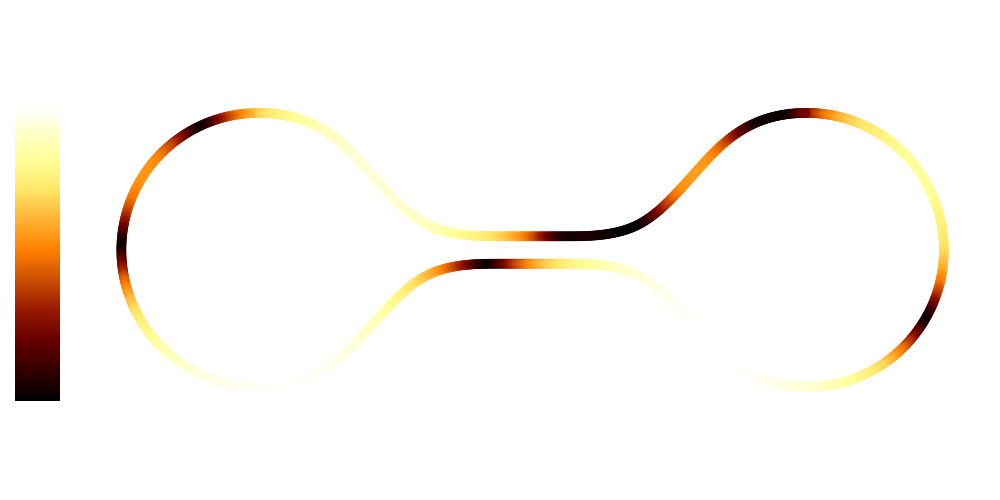

In [16]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=std_manifold, cmap=cmap_std)
colorbar(im, fig, ax)
beautify(fig, ax)

### Ambient Posterior Standard Deviation

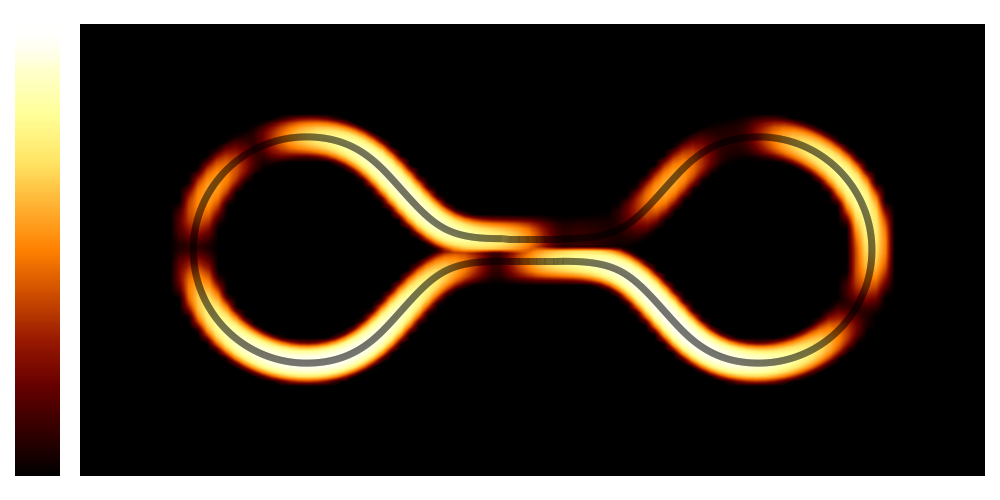

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x, y, std_ambient, 500, cmap=cmap_std)
# ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
#        edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = sampled_x[edge[0]]
    end = sampled_x[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth=5, alpha=0.1)
colorbar(im, fig, ax)
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

### Manifold Kernel

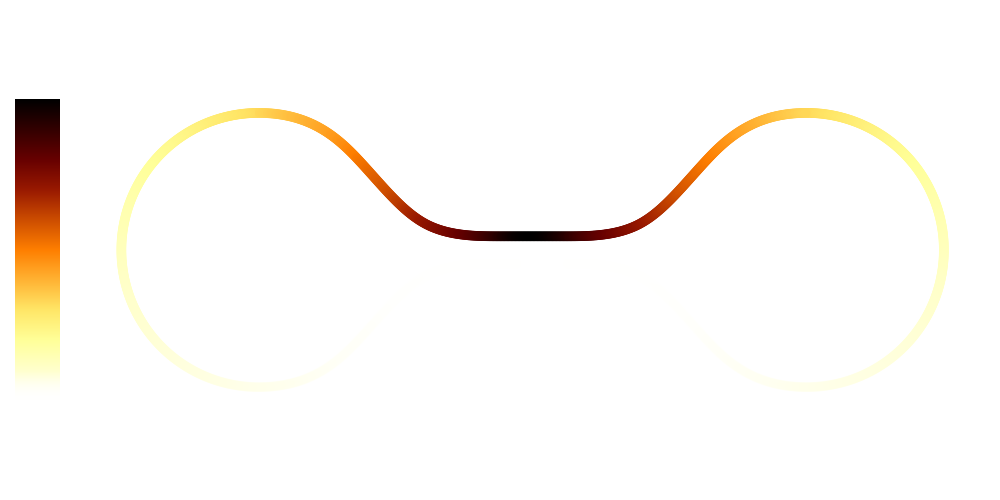

In [18]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=kernel_manifold, cmap=cmap_kernel)
colorbar(im, fig, ax)
beautify(fig, ax)

### Ambient Kernel

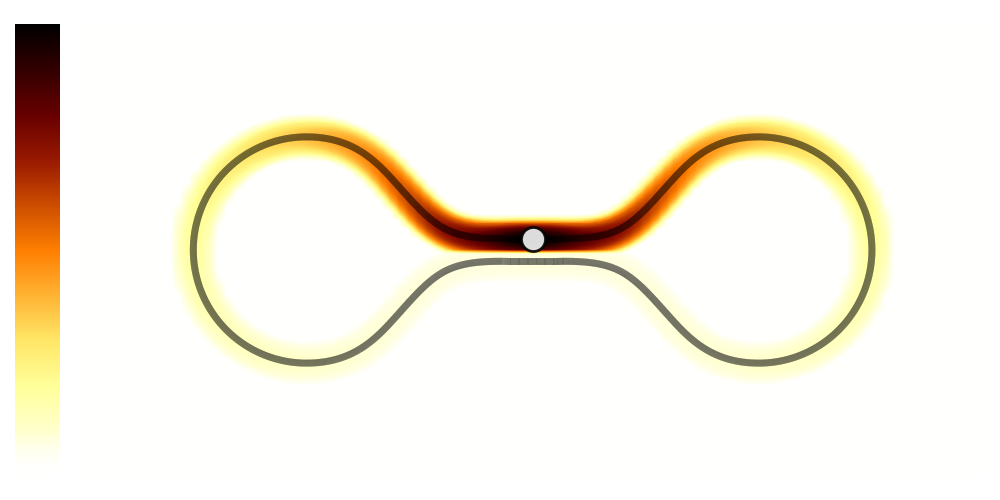

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x, y, kernel_ambient, 500, cmap=cmap_kernel)
ax.scatter(sampled_x[kernel_center, 0], sampled_x[kernel_center, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
       edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = sampled_x[edge[0]]
    end = sampled_x[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

### Manifold Feature

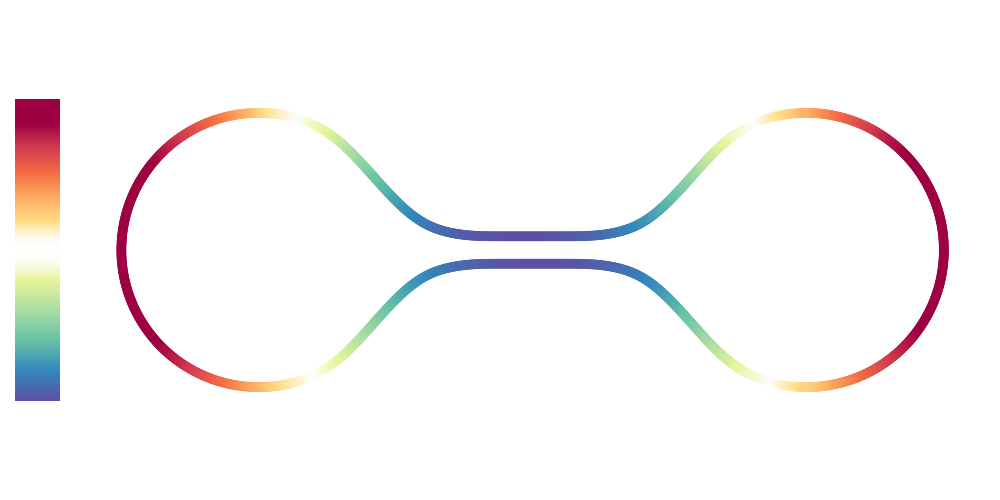

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=feature_manifold, cmap=cmap_feature)
colorbar(im, fig, ax)
beautify(fig, ax)

### Ambient Feature

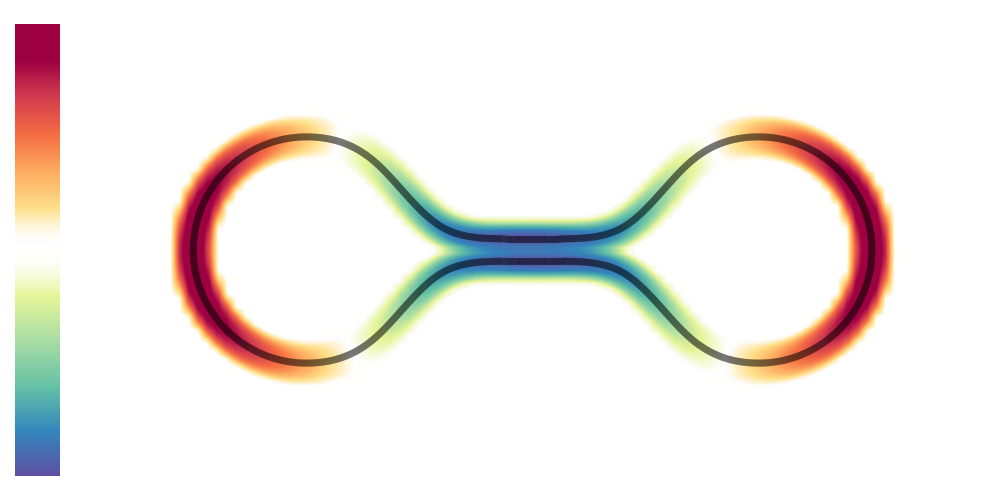

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x, y, feature_ambient, 500, cmap=cmap_feature)
for edge in edges:
    start = sampled_x[edge[0]]
    end = sampled_x[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
colorbar(im, fig, ax)
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

### Manifold Bump Function

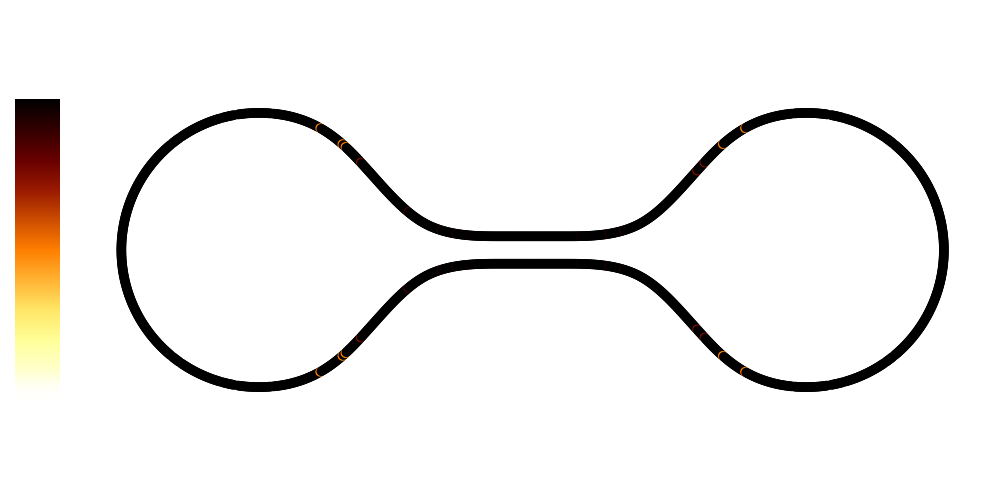

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=bump_manifold, cmap=cmap_kernel)
colorbar(im, fig, ax)
beautify(fig, ax)

### Ambient Bump Function

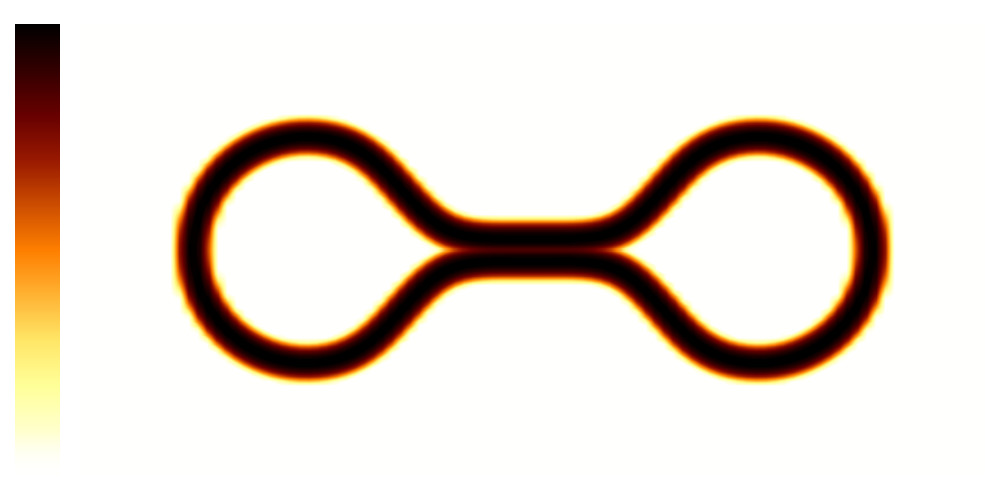

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x, y, bump_ambient, 500, cmap=cmap_kernel)
for edge in edges:
    start = sampled_x[edge[0]]
    end = sampled_x[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
colorbar(im, fig, ax)
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")